In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [15]:
#dataset = UCI breast cancer
with open("breast-cancer.names") as f:
    print(f.read())

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [14]:
#dataset = UCI heart disease
names=['class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irridant']
df = pd.read_csv('breast-cancer.data',names=names)
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irridant
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [16]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#checking missing values
df.isnull().sum()

no-recurrence-events    201
recurrence-events        85
Name: class, dtype: int64
50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: age, dtype: int64
premeno    150
ge40       129
lt40         7
Name: menopause, dtype: int64
30-34    60
25-29    54
20-24    50
15-19    30
10-14    28
40-44    22
35-39    19
0-4       8
50-54     8
5-9       4
45-49     3
Name: tumor-size, dtype: int64
0-2      213
3-5       36
6-8       17
9-11      10
15-17      6
12-14      3
24-26      1
Name: inv-nodes, dtype: int64
no     222
yes     56
?        8
Name: node-caps, dtype: int64
2    130
3     85
1     71
Name: deg-malig, dtype: int64
left     152
right    134
Name: breast, dtype: int64
left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast-quad, dtype: int64
no     218
yes     68
Name: irridant, dtype: int64


class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irridant       0
dtype: int64

In [17]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [18]:
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irridant
0,0,1,2,5,0,1,2,0,2,0
1,0,2,2,3,0,1,1,1,5,0
2,0,2,2,3,0,1,1,0,2,0
3,0,4,0,2,0,1,1,1,3,0
4,0,2,2,0,0,1,1,1,4,0


In [19]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [20]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [22]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=100)
  #maximum accuracy score
  acc_max=optimizer.fx_opt
  #best parameters
  params_best=optimizer.x_opt
  print(acc_max)
  print(params_best)
  optimizer.plot_convergence()
  optimizer.plot_acquisition()

In [23]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 7)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (2, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

-0.7699999999999999
[ 3.71960567 69.26078796]


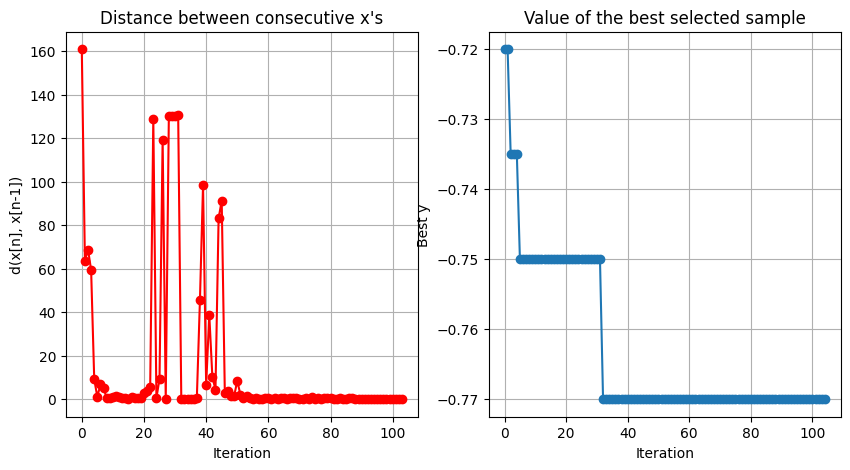

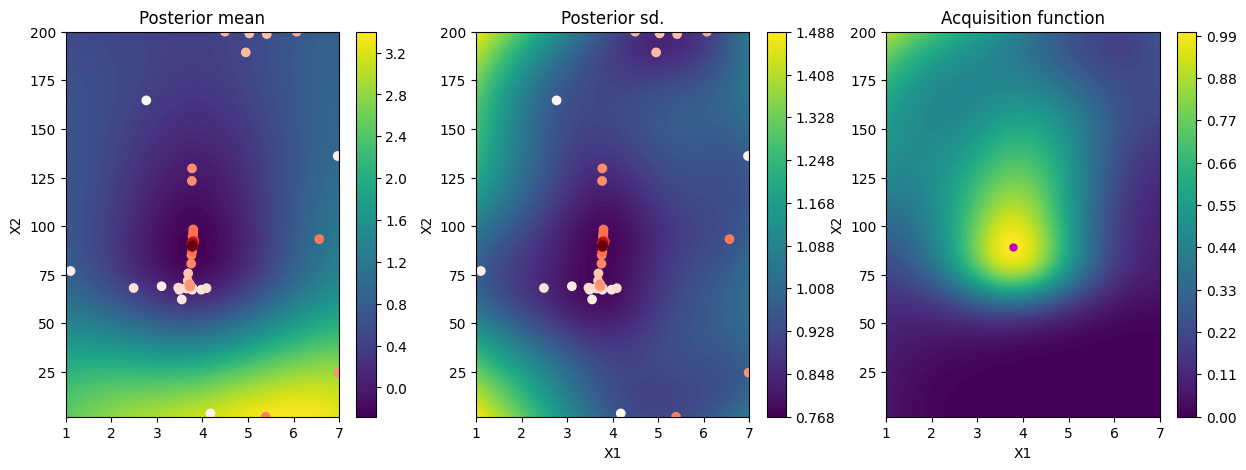

In [24]:
#RF Classification - Matern52 kernel
kernelM = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(rf_score,kernelM)

In [25]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=4,n_estimators=69)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.686046511627907
0.6744186046511628
0.6511627906976745
0.6744186046511628
0.6627906976744186
mean accuracy 0.6697674418604651


-0.76
[ 2.12922682 28.39182838]


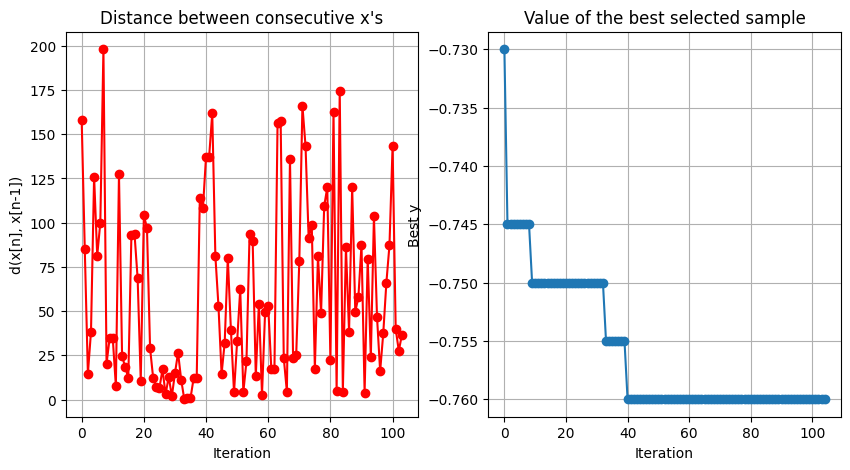

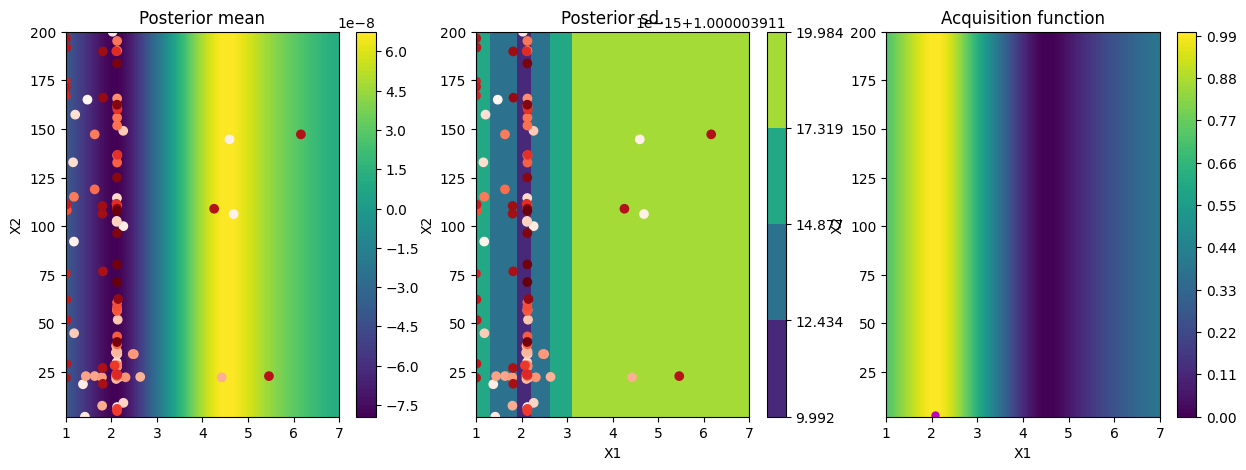

In [26]:
#RF Classification - Custom kernel
kernel1 = GPy.kern.Matern52(input_dim=1,variance=0.44,lengthscale=18,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1.66e-12,lengthscale=5.43,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=9.696,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.2655,lengthscale=56.74,active_dims=[1])
kernelR = kernel1 + kernel2 + kernel3
BO(rf_score,kernelR)

In [27]:
meanacc=[]
for i in range(5):
  rf_car = RandomForestClassifier(max_features=2,n_estimators=28)
  rf_car.fit(X_train,y_train)
  y_pred = rf_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.6627906976744186
0.6627906976744186
0.686046511627907
0.686046511627907
0.6744186046511628
mean accuracy 0.6744186046511628


In [28]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma': parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.76
[11.95439772  0.06971602]


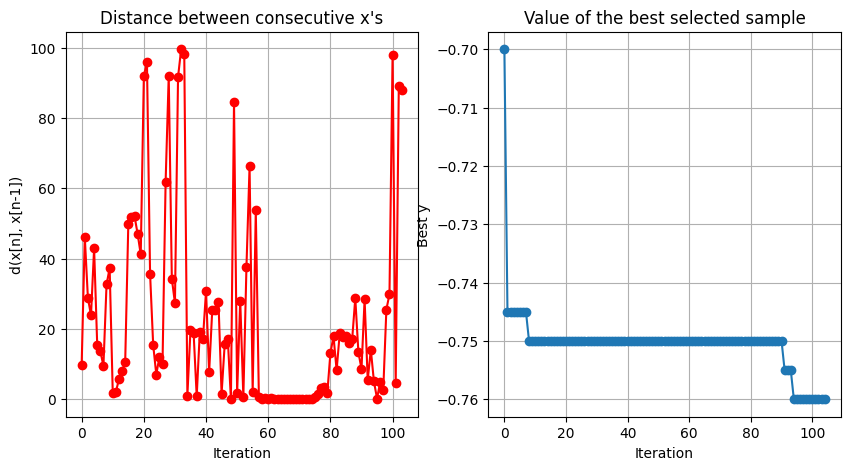

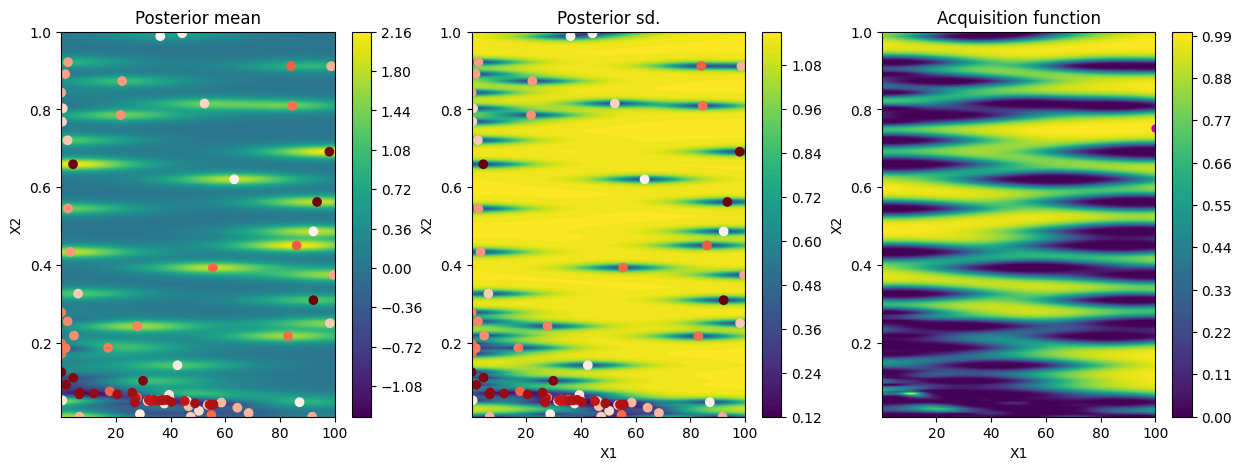

In [29]:
#SVM Classification - Matern52 kernel
kernel1 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(svm_score,kernel1)

In [30]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=11.95439772,gamma=0.06971602)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.6744186046511628
0.6744186046511628
0.6744186046511628
0.6744186046511628
0.6744186046511628
mean accuracy 0.6744186046511628


-0.75
[40.96648907  0.050882  ]


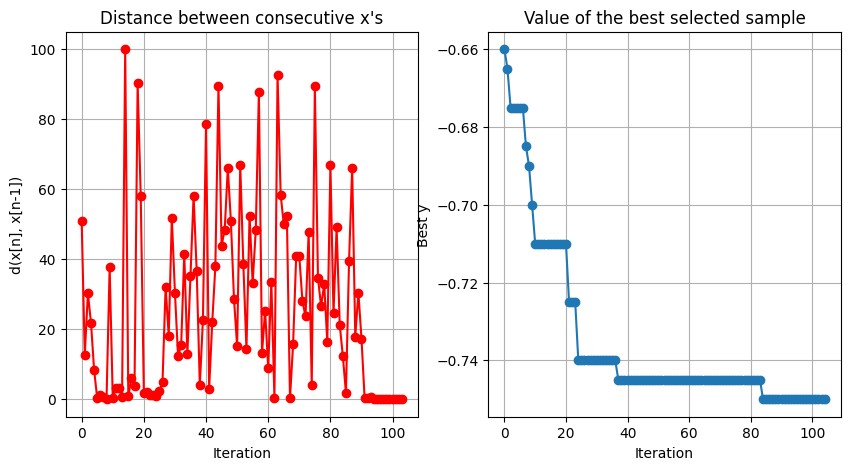

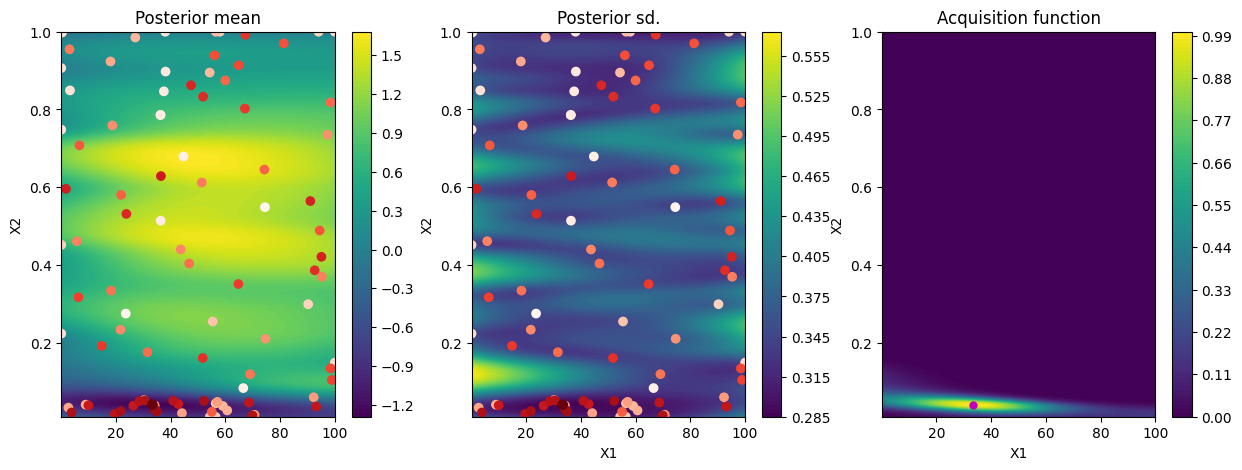

In [31]:
#SVM Classification - Custom kernel
kernelS = GPy.kern.Matern52(input_dim=1, variance=0.75558	, lengthscale=5.528,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=0.75558, lengthscale=0.4553,active_dims=[1])
BO(svm_score,kernelS)

In [32]:
meanacc=[]
for i in range(5):
  svm_car = svm.SVC(C=40.96648907,gamma=0.050882)
  svm_car.fit(X_train,y_train)
  y_pred = svm_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.686046511627907
0.686046511627907
0.686046511627907
0.686046511627907
0.686046511627907
mean accuracy 0.686046511627907


In [33]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.72
[33.34949714  7.        ]


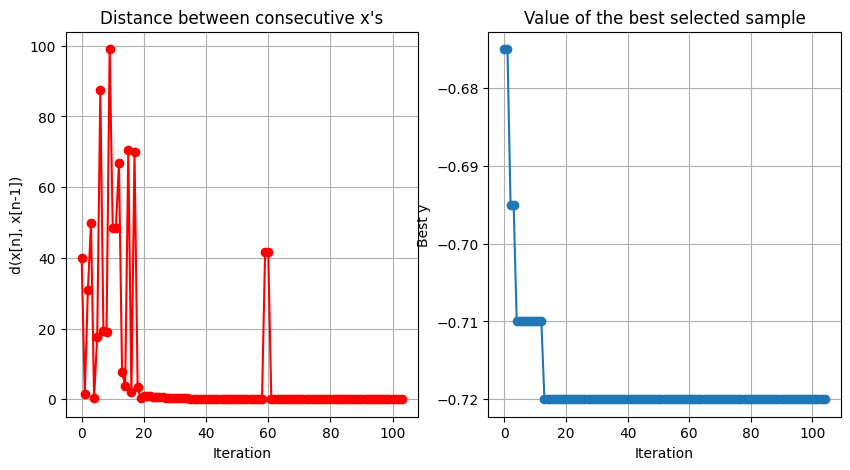

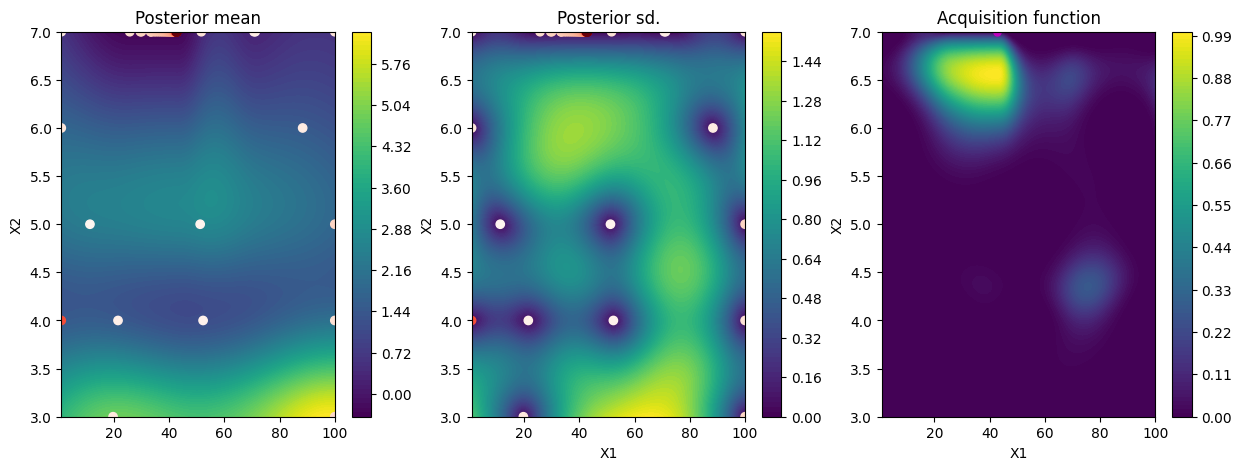

In [34]:
#KNN Classification - Matern52 kernel
kernelK = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[0]) * GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0,active_dims=[1])
BO(knn_score,kernelK)

In [35]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=33,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
mean accuracy 0.6627906976744186


-0.72
[25.83788489  7.        ]


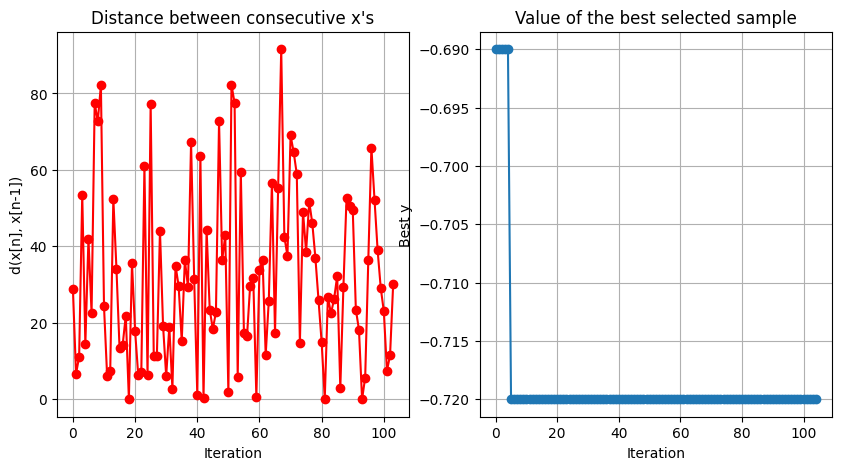

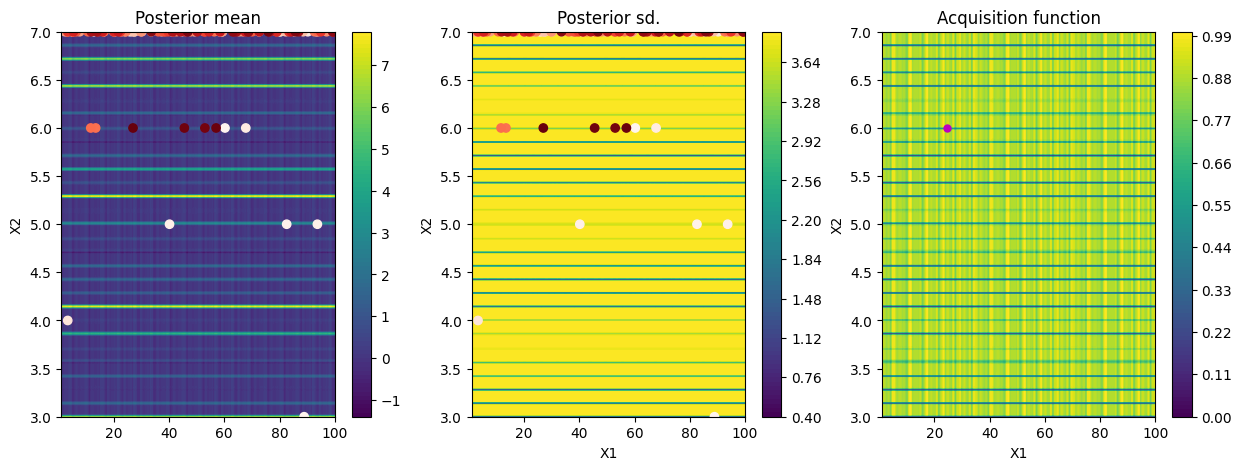

In [36]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=9.31e-09,lengthscale=71.5,active_dims=[0],period=13)
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.67,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

In [38]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=26,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
mean accuracy 0.6627906976744186


-0.72
[38.13332279  7.        ]


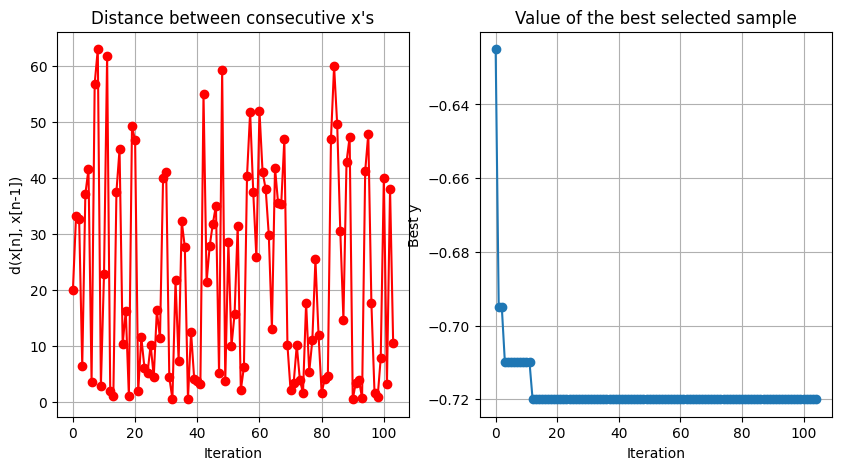

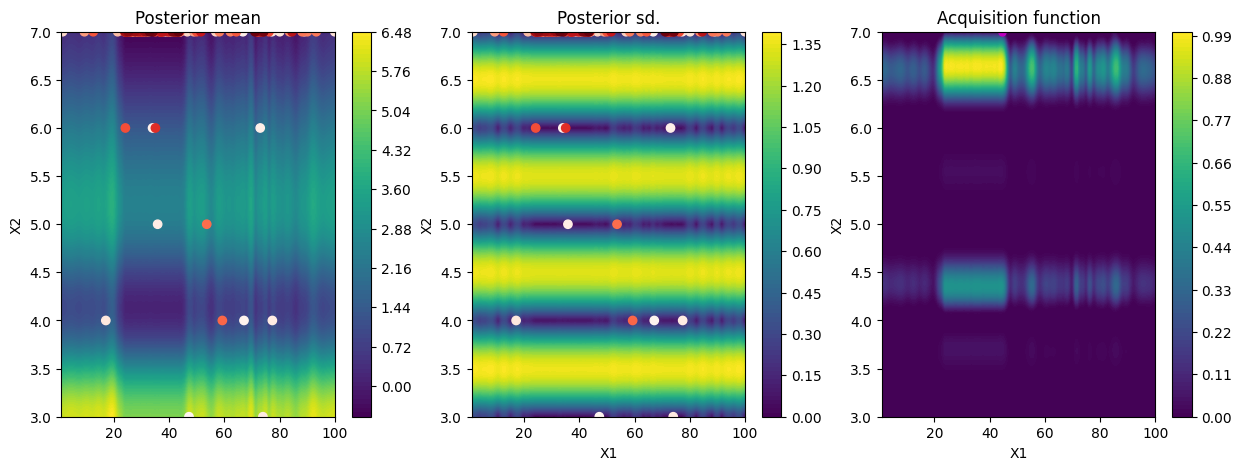

In [37]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=4.372e-14	,lengthscale=1.00,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,variance = 4.372e-14,lengthscale=1.018,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.3117,lengthscale=1.789,active_dims=[1],period=2)
kernelK = kernel1 + kernel2
BO(knn_score,kernelK)

In [39]:
meanacc=[]
for i in range(5):
  knn_car = KNeighborsClassifier(leaf_size=38,n_neighbors=7)
  knn_car.fit(X_train,y_train)
  y_pred = knn_car.predict(X_test)
  accuracy_test = accuracy_score(y_pred,y_test)
  print(accuracy_test)
  meanacc.append(accuracy_test)

print("mean accuracy",np.mean(meanacc))

0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
0.6627906976744186
mean accuracy 0.6627906976744186
